# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import nbformat
from nbconvert import HTMLExporter
from IPython.display import display, Javascript
import seaborn as sns
import copy
import os

# How to use
This notebook was prepared primarly for data analysis and visualization of custom benchmark metrics. However, if you want to make the data analysis of single result of other cathegory benchmark, you can skip the `Route quality` section and still run the notebook.
Before running the notebook, please provide a benchamrk results csv as a `path` in User input section. You can also specify a name of resulting HTML file as a `filename` in the same section. To perform the analysis provide the neccessary user input and run the notebook.
 By executing final section of the notebook, you can convert the results to HTML and save them in `data_analysis_results` folder. If you want to add notes and comments, just convert the given HTML to PDF in you browser. 
 ### PLEASE REMEMBER TO SAVE NOTEBOOK BEFORE EXPORTING IF TO HTML!!!

# User input

## Defining benchmark file path

In [2]:
#"benchmark_results/2024-11-15_14-54-00/custom_benchmark_results_2024-11-15_14-54-00.csv"
#path = "benchmark_results/2024-11-15_19-49-09/custom_benchmark_results_2024-11-15_19-49-09.csv"
#path = "benchmark_results/2024-11-15_22-15-08/custom_benchmark_results_2024-11-15_22-15-08.csv"
path = "benchmark_results/2024-11-20_16-19-27/custom_benchmark_results_2024-11-20_16-19-27.csv"

## (optional) Define data analysis file name

In [3]:
filename = 'Not integrated with OSMR yet full benchmark'

In [4]:
if filename is None:
    filename = path.split("/")[-1]
    filename = filename.split(".")[0]
    filename += "-analysis"

# Preprocessing

In [5]:
def time_to_minutes(time_str):
    if pd.isna(time_str):
        return None
    h, m, s = map(int, time_str.split(':'))
    return h * 60 + m + s / 60

In [6]:
df = pd.read_csv(path, encoding = "ISO-8859-2")
df['found route duration (min)'] = df['found route duration'].apply(time_to_minutes)
df['Label'] = df['Start name'] + ' -> ' + df['Destination Name'] + ' (' + df['Start Time'] + ' '+ df['Day of week'] + ')'
num_rows = len(df)
fig_height = num_rows / 3.8

# Plots

## Route quality

In [7]:
df['jak dojade duration (min)'] = df['jak dojade duration'].apply(time_to_minutes)
df['google duration (min)'] = df['google route duration'].apply(time_to_minutes)
df['duration dojade - found route (min)'] = df.apply(
    lambda row: row['jak dojade duration (min)'] - row['found route duration (min)'] if pd.notna(row['found route duration (min)']) else None,
    axis=1
)
df['duration google - found route (min)'] = df.apply(
    lambda row: row['google duration (min)'] - row['found route duration (min)'] if pd.notna(row['found route duration (min)']) else None,
    axis=1
)

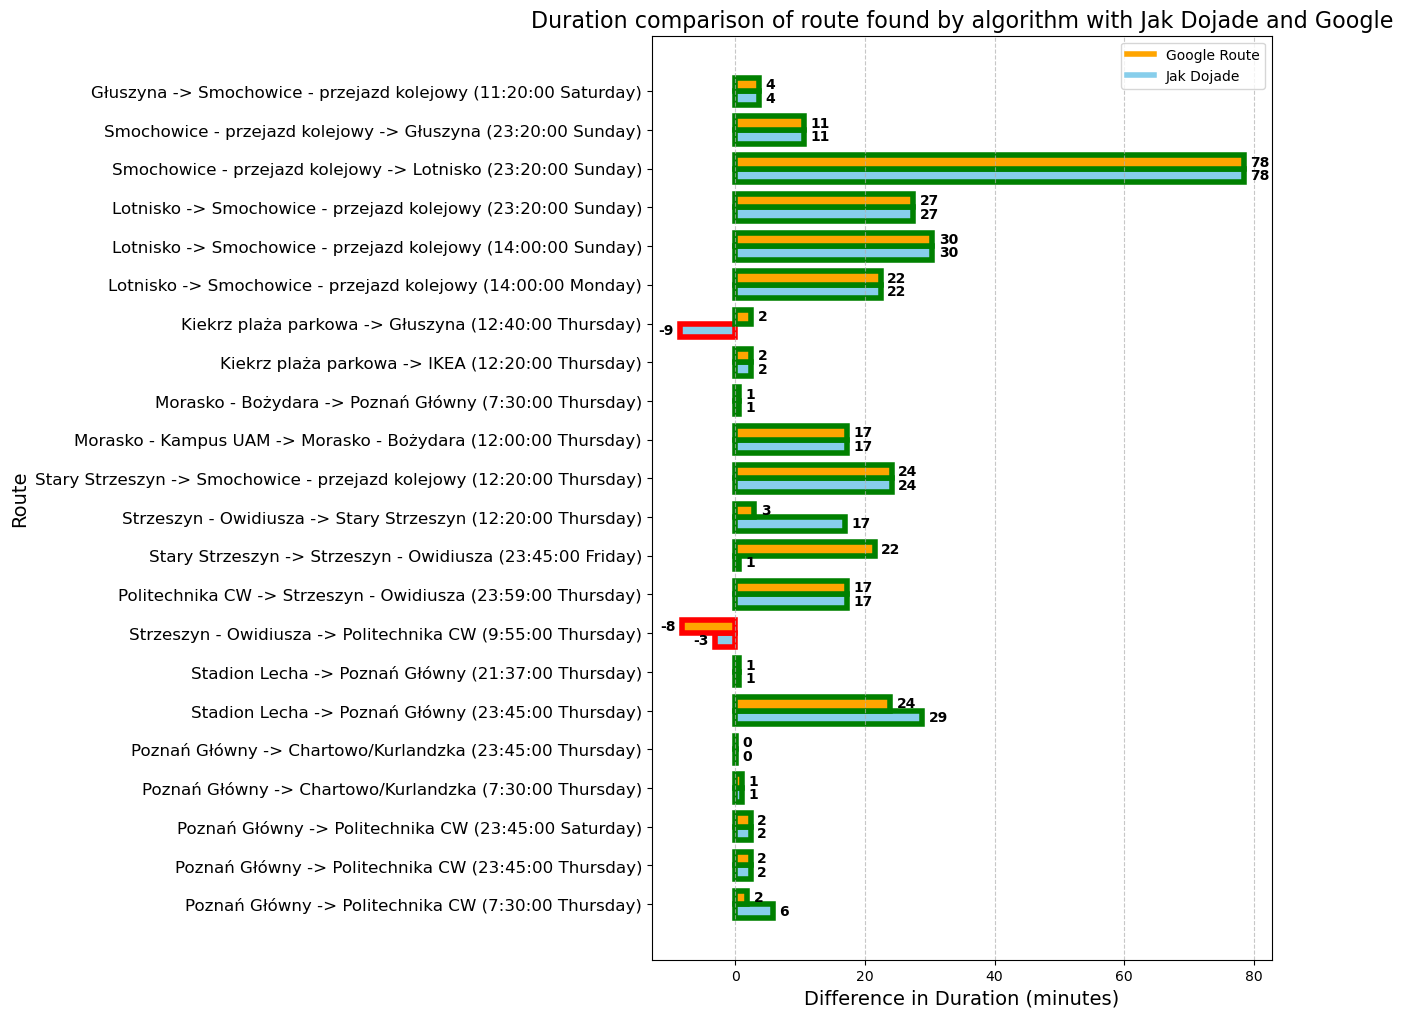

In [8]:
fig, ax = plt.subplots(figsize=(8, 12))

bar_width = 0.35
index = range(len(df))

bars1 = ax.barh([i - bar_width/2 for i in index], df['duration dojade - found route (min)'].fillna(0), bar_width, color='skyblue', edgecolor=['green' if x > 0 else 'red' for x in df['duration dojade - found route (min)'].fillna(0)], linewidth=1.5, label='Jak Dojade')
bars2 = ax.barh([i + bar_width/2 for i in index], df['duration google - found route (min)'].fillna(0), bar_width, color='orange', edgecolor=['green' if x > 0 else 'red' for x in df['duration google - found route (min)'].fillna(0)], linewidth=1.5, label='Google Route')

for bars in [bars1, bars2]:
    for bar in bars:
        bar.set_edgecolor(bar.get_edgecolor())
        bar.set_linewidth(4)
        bar.set_path_effects([])  # Clear any existing path effects
        bar.set_clip_on(False)
        bar.set_capstyle('round')

ax.set_yticks(index)
ax.set_yticklabels(df['Label'], fontsize=12)

plt.ylabel('Route',fontsize=14)
plt.xlabel('Difference in Duration (minutes)', fontsize=14)
plt.title('Duration comparison of route found by algorithm with Jak Dojade and Google', fontsize=16)

for bars, diffs in zip([bars1, bars2], [df['duration dojade - found route (min)'], df['duration google - found route (min)']]):
    for bar, diff in zip(bars, diffs):
        xval = bar.get_width()
        offset = 1  # Adjust this value to set the distance from the bar end
        if pd.isna(diff):
            plt.text(0, bar.get_y() + bar.get_height()/2, 'NA', ha='center', va='center', color='black', fontsize=10, fontweight='bold')
        else:
            if xval > 0:
                plt.text(xval + offset, bar.get_y() + bar.get_height()/2, round(xval), ha='left', va='center', color='black', fontsize=10, fontweight='bold')
            else:
                plt.text(xval - offset, bar.get_y() + bar.get_height()/2, round(xval), ha='right', va='center', color='black', fontsize=10, fontweight='bold')

legend_elements = [
    Line2D([0], [0], color='orange', lw=4, label='Google Route'),
    Line2D([0], [0], color='skyblue', lw=4, label='Jak Dojade')
    
]
ax.legend(handles=legend_elements)

plt.grid(axis='x', linestyle='--', alpha=0.7)
#plt.tight_layout()
plt.show()

## Searching time components

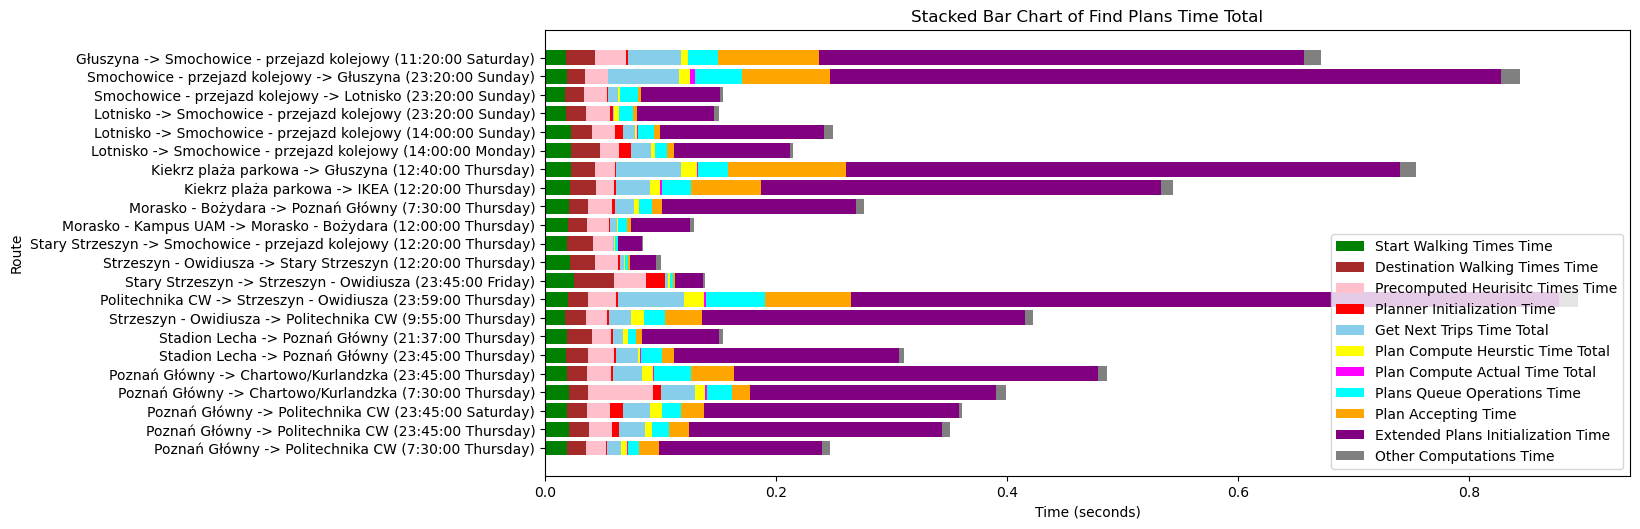

In [9]:
all_columns = [
    'prospecting_time',
    'start_walking_times_time',
    'destination_walking_times_time',
    'precomputed_heurisitc_times_time',
    'planner_initialization_time',
    'get_next_trips_time_total',
    'plan_compute_heurstic_time_total',
    'plan_compute_actual_time_total',
    'plans_queue_operations_time',
    'plan_accepting_time',
    'extended_plans_initialization_time',
]

color_map = {
    'prospecting_time': 'green',
    'start_walking_times_time': 'green',
    'destination_walking_times_time': 'brown',
    'precomputed_heurisitc_times_time': 'pink',
    'planner_initialization_time': 'red',
    'get_next_trips_time_total': 'skyblue',
    'plan_compute_heurstic_time_total': 'yellow',
    'plan_compute_actual_time_total': 'magenta',
    'plans_queue_operations_time': 'cyan',
    'plan_accepting_time': 'orange',
    'extended_plans_initialization_time': 'purple',
    'other_computations_time': 'gray',
}

columns = [c for c in all_columns if c in df]

df['other_computations_time'] = df['find_plans_time_total'] - df[columns].sum(axis=1, skipna=True)

df['other_computations_time'] = df['other_computations_time'].apply(lambda x: max(x, 0))

fig, ax = plt.subplots(figsize=(14, fig_height))

bottom = pd.Series([0] * len(df))
for column in columns:
    if column in df:
        ax.barh(df['Label'], df[column], color=color_map[column], left=bottom, label=column.replace('_', ' ').title())
        bottom += df[column]

ax.barh(df['Label'], df['other_computations_time'], color=color_map['other_computations_time'], left=bottom, label='Other Computations Time')

plt.xlabel('Time (seconds)')
plt.ylabel('Route')
plt.title('Stacked Bar Chart of Find Plans Time Total')
plt.legend()

plt.show()

## Distribution of cost metrics

In [10]:
def plot_distribution_histogram(metric, title, xlabel):
    plt.figure(figsize=(14, 8))

    sns.histplot(df[metric], color='orange', stat="density", linewidth=0, alpha=0.3, bins=20)
    sns.kdeplot(df[metric], color='orange', lw=5)

    median1 = df[metric].median()
    mean1 = df[metric].mean()
    plt.axvline(median1, color='orange', linestyle='--', linewidth=2, label=f'Median: {round(median1, 2)}')
    plt.axvline(mean1, color='orange', linestyle='-', linewidth=2, label=f'Mean: {round(mean1, 2)}')

    plt.gca().set_yticklabels([])
    plt.xlim(left=0)
    plt.xlabel(xlabel)
    #plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()

    plt.tight_layout()
    plt.show()

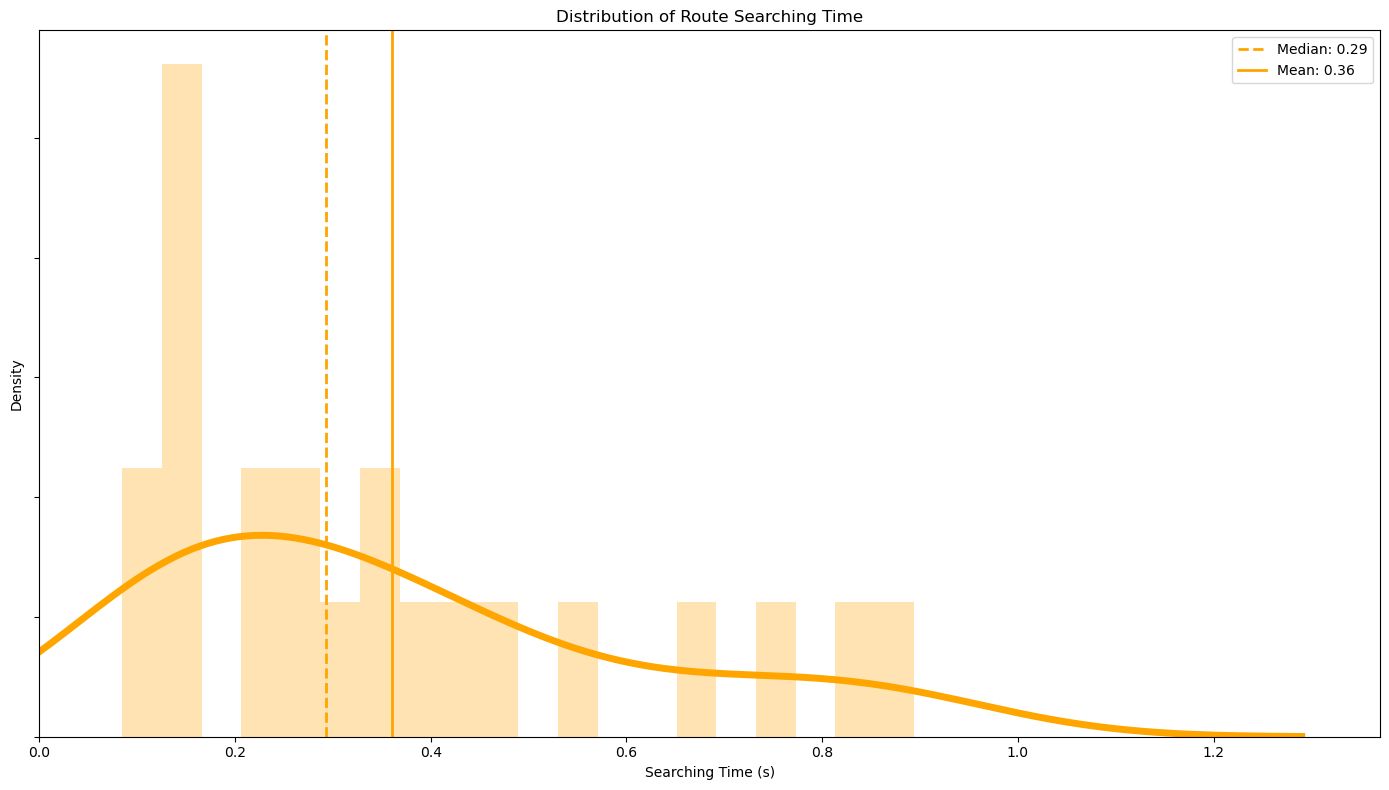

In [11]:
plot_distribution_histogram(
    metric='find_plans_time_total', 
    title='Distribution of Route Searching Time', 
    xlabel='Searching Time (s)', 
)

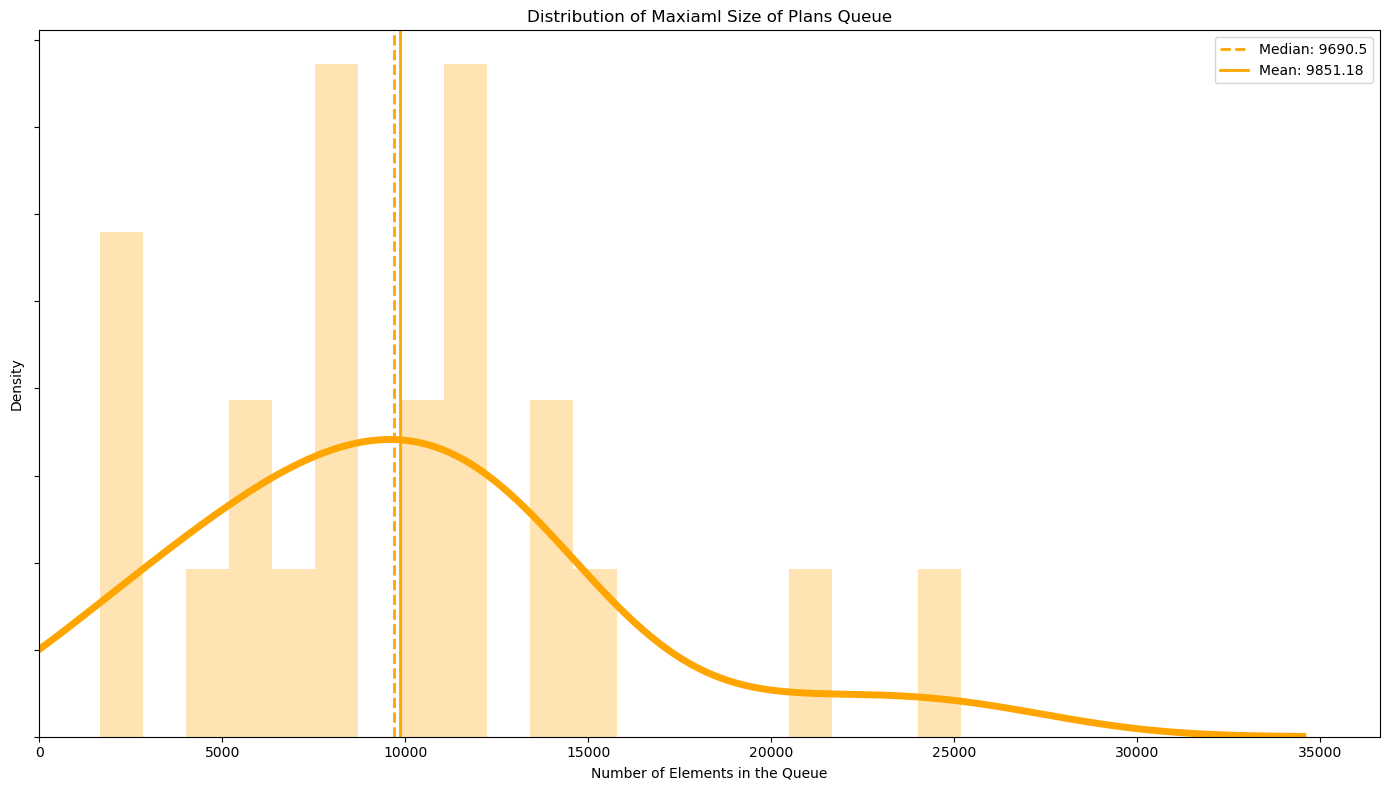

In [12]:
plot_distribution_histogram(
    metric='plans_queue_max_size', 
    title='Distribution of Maxiaml Size of Plans Queue', 
    xlabel='Number of Elements in the Queue', 
)

## Qulitative analysis of A* expansions

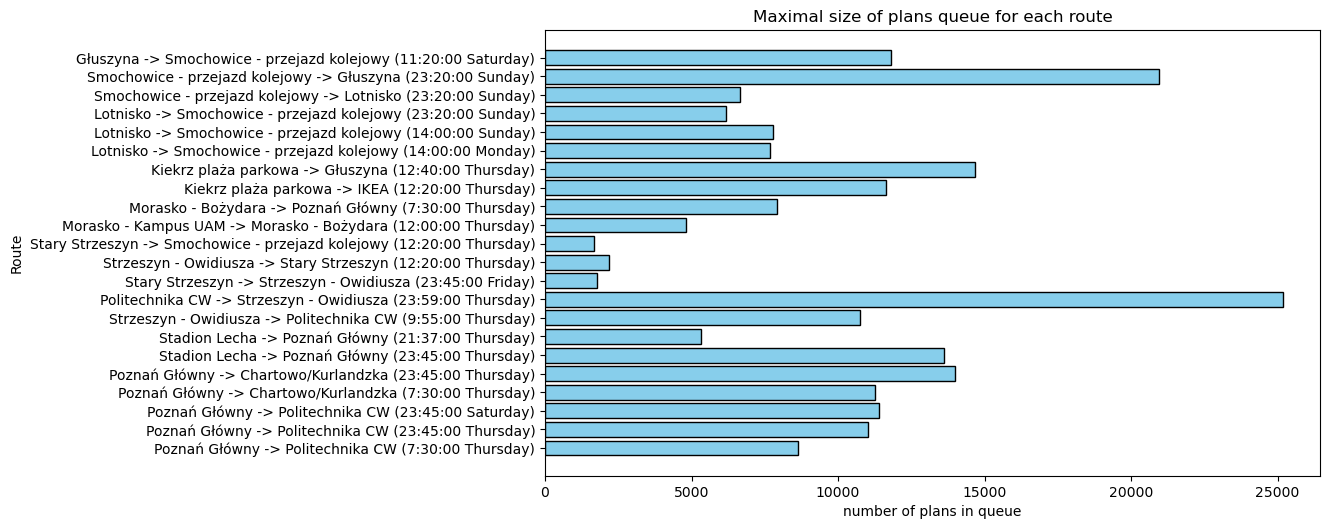

In [13]:
fig, ax = plt.subplots(figsize=(10, fig_height))

ax.barh(df['Label'], df['plans_queue_max_size'], color='skyblue', edgecolor='black')

plt.xlabel('number of plans in queue')
plt.ylabel('Route')
plt.title('Maximal size of plans queue for each route')

plt.show()

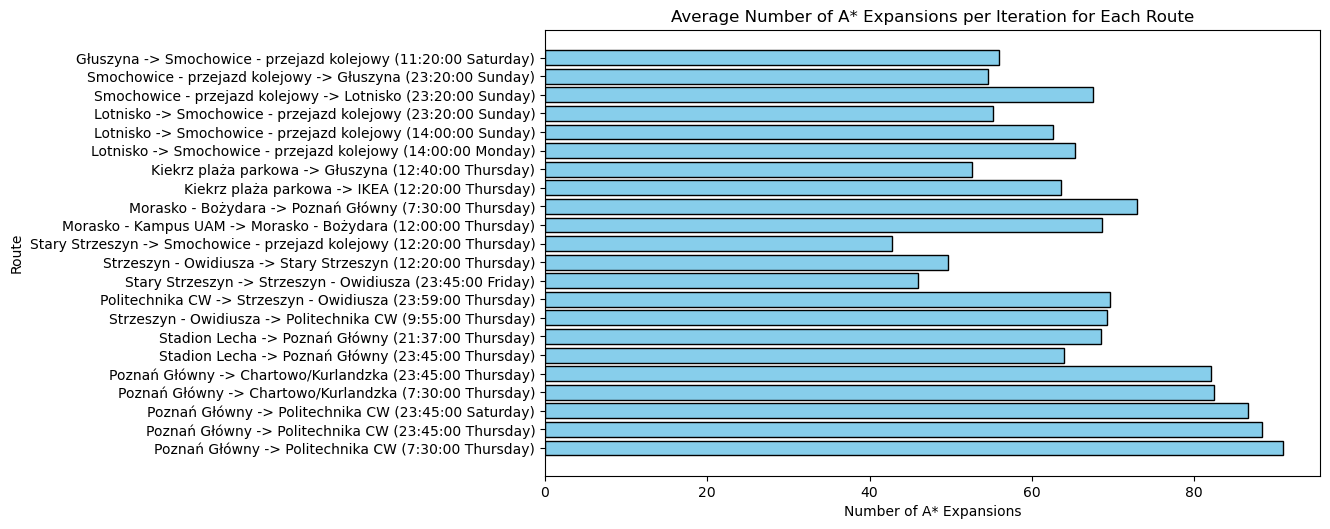

In [14]:
df['avg_expansions_per_iteration'] = df['expansions_total'] / df['iterations']

fig, ax = plt.subplots(figsize=(10, fig_height))

ax.barh(df['Label'], df['avg_expansions_per_iteration'], color='skyblue', edgecolor='black')

plt.xlabel('Number of A* Expansions')
plt.ylabel('Route')
plt.title('Average Number of A* Expansions per Iteration for Each Route')

plt.show()

### The purpose of the next two plots is to get better understanding of how A* works in this application, rather than analysing performance

currently there is an issue with unique stops visited metric so its results are incorrect

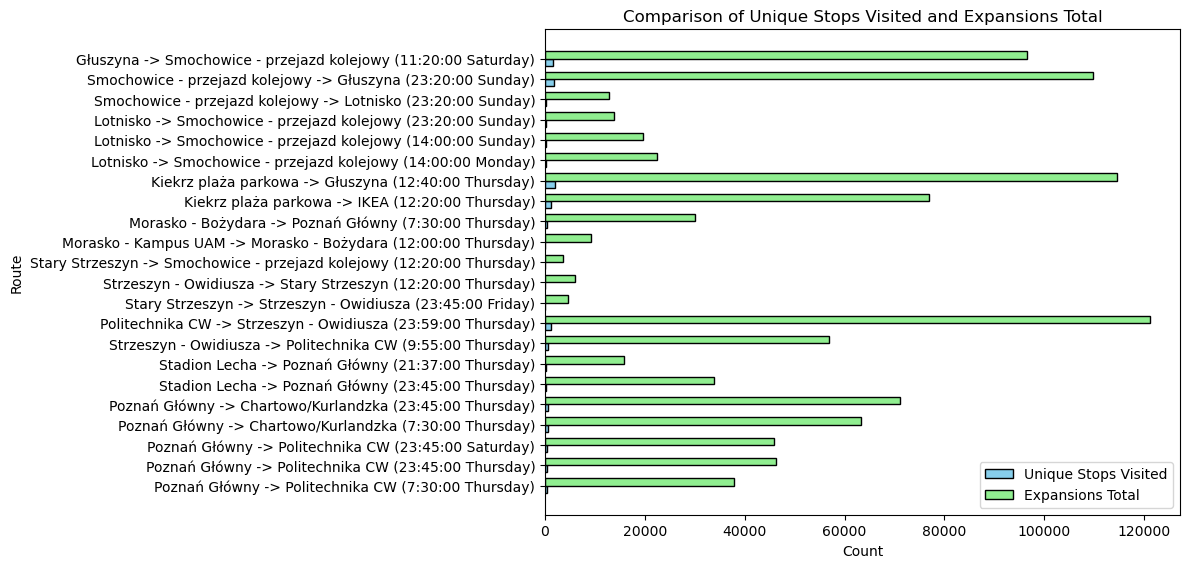

In [15]:
fig, ax = plt.subplots(figsize=(12, fig_height))

bar_height = 0.35

index = np.arange(len(df['Label']))

bars1 = ax.barh(index - bar_height/2, df['unique_stops_visited'], bar_height, label='Unique Stops Visited', color='skyblue', edgecolor='black')
bars2 = ax.barh(index + bar_height/2, df['expansions_total'], bar_height, label='Expansions Total', color='lightgreen', edgecolor='black')

ax.set_ylabel('Route')
ax.set_xlabel('Count')
ax.set_title('Comparison of Unique Stops Visited and Expansions Total')
ax.set_yticks(index)
ax.set_yticklabels(df['Label'])
ax.legend()

plt.tight_layout()
plt.show()

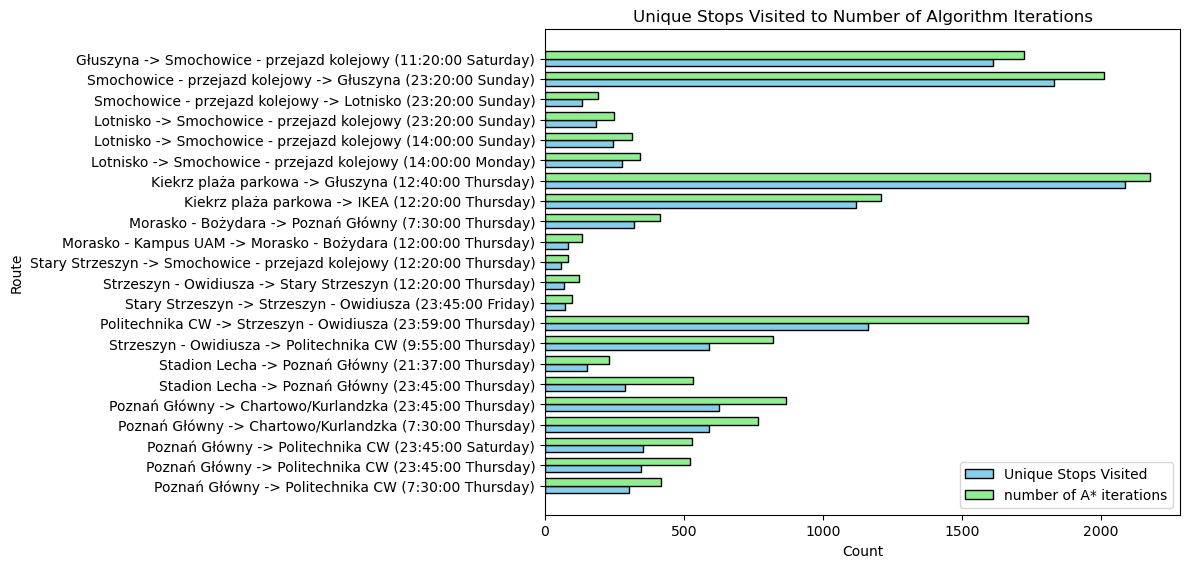

In [16]:
fig, ax = plt.subplots(figsize=(12, fig_height))

bar_height = 0.35

index = np.arange(len(df['Label']))

bars1 = ax.barh(index - bar_height/2, df['unique_stops_visited'], bar_height, label='Unique Stops Visited', color='skyblue', edgecolor='black')
bars2 = ax.barh(index + bar_height/2, df['iterations'], bar_height, label='number of A* iterations', color='lightgreen', edgecolor='black')

ax.set_ylabel('Route')
ax.set_xlabel('Count')
ax.set_title('Unique Stops Visited to Number of Algorithm Iterations')
ax.set_yticks(index)
ax.set_yticklabels(df['Label'])
ax.legend()

plt.tight_layout()
plt.show()

# Saving analysis to PDF

In [18]:
def save_notebook():
    display(Javascript("IPython.notebook.save_checkpoint();"))
save_notebook()
notebook_filename = 'custom_benchmark_data_analysis.ipynb'
with open(notebook_filename) as f:
    nb = nbformat.read(f, as_version=4)

nb_copy = copy.deepcopy(nb)

nb_copy['cells'] = [cell for cell in nb_copy['cells'] if not (
    'tags' in cell['metadata'] and
    ('hide_all' in cell['metadata']['tags'] or 'hide_markdown' in cell['metadata']['tags'])
)]
for cell in nb_copy['cells']:
    if 'tags' in cell['metadata']:
        if 'hide_code' in cell['metadata']['tags']:
            cell['source'] = ''  # Clear the source to hide the input

html_exporter = HTMLExporter()
html_data, resources = html_exporter.from_notebook_node(nb_copy)

output_dir = 'data_analysis_results'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

html_filename = os.path.join(output_dir, filename + '.html')
with open(html_filename, 'w') as f:
    f.write(html_data)

print(f'Notebook has been converted to HTML and saved as {html_filename}')

<IPython.core.display.Javascript object>

Notebook has been converted to HTML and saved as data_analysis_results\Not integrated with OSMR yet full benchmark.html
